In [1]:
%matplotlib inline
# plt.style.use('dark_background')
import os, sys
sep = os.path.sep
# loading modules from https://bitbucket.org/yzerlaut/common_libraries
sys.path.append(os.path.expanduser('~')+sep+'work'+sep+'datavYZ')
from graphs.my_graph import set_plot
from IO.binary_to_python import load_file

In [77]:
from sklearn import mixture

def hvsd(x):
    return .5*(1.+np.sign(x))*x

def fit_gaussians(Vm, n=1000, ninit=3, bound1=-90, bound2=-35):
    # clf = mixture.GaussianMixture(n_components=2, max_iter=n, n_init=ninit, means_init=((-80,), (-50,)), covariance_type='spherical')
    clf = mixture.GaussianMixture(n_components=3, max_iter=n, n_init=ninit, means_init=((-80,), (-65,), (-50,)), covariance_type='spherical')
    clf.fit(np.array((Vm[(Vm>bound1) & (Vm<bound2)],)).T)
    return clf.weights_, clf.means_.flatten(), np.sqrt(clf.covariances_)

def gaussian(X, m, s):
    Y = np.exp(-(X-m)**2/2./s**2)
    return Y/Y.sum()

def determine_thresholds(weights, means, stds):
    """ Gives the thresholds given the Gaussian Mixture"""
    i0, i1 = np.argmin(means[0:2]), np.argmax(means[1:3])+1
    alpha = 1.-np.exp(-hvsd(means[i1]-2.*stds[i1]-means[i0]-2.*stds[i0])/5.)
    return means[i0]+2.*alpha*stds[i0], means[i1]-2.*alpha*stds[i1] 

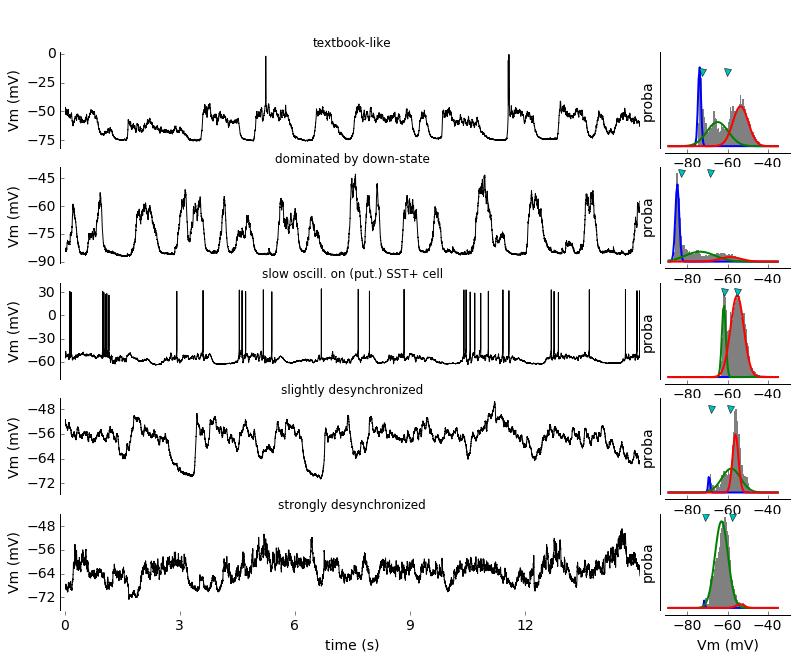

In [83]:
prefix = os.path.expanduser('~')+sep+'DATA'+sep+'Exps_Ste_and_Yann'+sep
FILES = [prefix+'2016_12_6'+sep+'16_36_05_VM-FEEDBACK--SPONT-ACT-SAMPLING.bin',
         prefix+'2016_11_30'+sep+'13_58_49_VM-FEEDBACK--SPONT-ACT-SAMPLING.bin',
         prefix+'2016_12_1'+sep+'14_51_58_VM-FEEDBACK--SPONT-ACT-SAMPLING.bin',
         prefix+'2016_12_1'+sep+'14_06_49_VM-FEEDBACK--OSTIM-AT-VARIOUS-DELAYS.bin',
         prefix+'2016_11_30'+sep+'14_22_26_VM-FEEDBACK--OPTO-STIM-VS-CTRL.bin']
ANNOT = ['textbook-like', 'dominated by down-state', 'slow oscill. on (put.) SST+ cell',\
         'slightly desynchronized', 'strongly desynchronized']

bound1, bound2 = -90, -35

N = 5
fig = plt.figure(figsize=(13, 2.*len(FILES)))
for i in range(len(FILES)):
    t, V = load_file(FILES[i], zoom=[-15.,np.inf])
    hist, BE = np.histogram(V[0], bins=np.linspace(bound1, bound2, 100))
    weights, means, stds = fit_gaussians(V[0])
    UD_threshold, DU_threshold = determine_thresholds(weights, means, stds)
    ax1 = plt.subplot2grid((len(FILES), N), (i, 0), colspan=N-1)
    ax1.set_title("\n"+"\n"+ANNOT[i], fontsize=12)
    ax1.plot(t-t[0], V[0], 'k-')
    set_plot(ax1, ["left"], ylabel="Vm (mV)", xticks=[], xlim=[0, t[-1]-t[0]])
    ax2 = plt.subplot2grid((len(FILES), N), (i, N-1))
    ax2.bar(BE[1:], hist/hist.sum(), lw=0, facecolor="gray")
    for w, m, s in zip(weights, means, stds):
        ax2.plot(BE[1:], w*gaussian(BE[1:], m, s), lw=2)
    ax2.plot([UD_threshold, DU_threshold], [hist.max()/hist.sum(), hist.max()/hist.sum()], 'v', ms=7)
    set_plot(ax2, xlabel="Vm (mV)", ylabel="proba", yticks=[])
set_plot(ax1, ["left", "bottom"], ylabel="Vm (mV)", xlabel="time (s)", xlim=[0, t[-1]-t[0]])
fig.savefig('/Users/yzerlaut/Desktop/1.png')

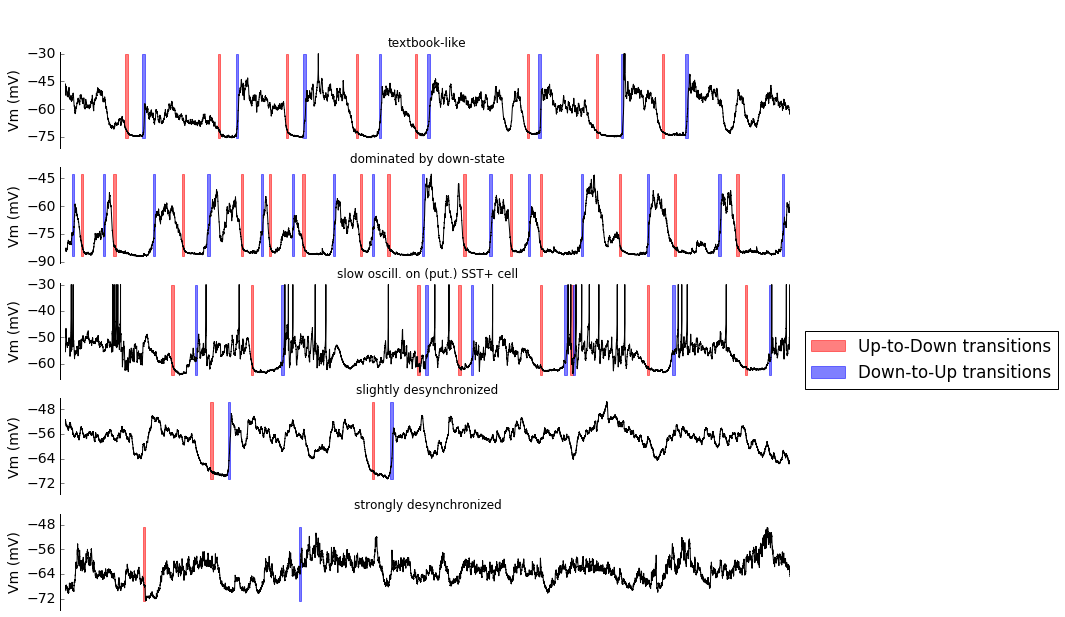

In [84]:
def state_transitions(Vm, UD_threshold, DU_threshold, tau=200):
    Vm[Vm>-30] = -30
    Vm = [Vm[max([i-100,0]):min([i+100,len(Vm)])].mean() for i in range(len(Vm))]
    down_flag = False
    if Vm[0]>UD_threshold:
        down_state = True
    UD_transitions, DU_transitions = [], []
    for i in range(len(Vm)):
        if Vm[i]>DU_threshold and down_flag:
            DU_transitions.append(i)
            down_flag = False
        if Vm[i]<UD_threshold and not down_flag:
            UD_transitions.append(i)
            down_flag = True
    return UD_transitions, DU_transitions

fig = plt.figure(figsize=(13, 2.*len(FILES)))
for i in range(len(FILES)):
    t, V = load_file(FILES[i], zoom=[-15.,np.inf])
    weights, means, stds = fit_gaussians(V[0])
    UD_threshold, DU_threshold = determine_thresholds(weights, means, stds)
    UD_transitions, DU_transitions = state_transitions(V[0], UD_threshold, DU_threshold)
    ax1 = plt.subplot2grid((len(FILES), N), (i, 0), colspan=N)
    ax1.set_title("\n"+"\n"+ANNOT[i], fontsize=12)
    ax1.plot(t-t[0], V[0], 'k-')
    for j in UD_transitions:
        tt = t[max([j-500,0]):j]
        b1 = ax1.fill_between(tt-t[0], V[0].max()+0*tt, V[0].min()+0*tt, color='r', alpha=.5)
    for j in DU_transitions:
        tt = t[max([j-500,0]):j]
        b2 = ax1.fill_between(tt-t[0], V[0].max()+0*tt, V[0].min()+0*tt, color='b', alpha=.5)
    set_plot(ax1, ["left"], ylabel="Vm (mV)", xticks=[], xlim=[0, t[-1]-t[0]])
ax1.legend([b1, b2], ['Up-to-Down transitions', 'Down-to-Up transitions'], loc = (1.02, 2.3))

In [82]:
1-np.exp(-1/2.)

0.39346934028736658